In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import PIL
from PIL import Image
import tqdm
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, matthews_corrcoef, roc_auc_score, roc_curve, auc

In [2]:
# Device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Constants

data_dir = '/kaggle/input/fdata-adni-dataset/AugmentedAlzheimerDataset'

TEST_SIZE = 0.15
VAL_SIZE = 0.15

MEAN = 0.2956
STD = 0.3069

MODEL_TAG = 'hf_hub:timm/swin_tiny_patch4_window7_224.ms_in22k'
NUM_CLASSES = 4

BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EPOCHS = 75
DECAY = 1e-4

PATIENCE = 5
MIN_DELTA = 0.05

RANDOM_SEED = 43

transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3)
])

In [4]:
# Seeds
torch.manual_seed(RANDOM_SEED)
generator = torch.Generator().manual_seed(RANDOM_SEED) # Surity

In [5]:
# Datasets

master = datasets.ImageFolder(root=data_dir, transform=transform)

total_size = len(master)
test_size = int(TEST_SIZE * total_size)
val_size = int(VAL_SIZE * total_size)
train_size = total_size - test_size - val_size

train_set, val_set, test_set = random_split(master, [train_size, val_size, test_size], generator=generator)

In [6]:
print(f'Train: {len(train_set)}\nVal: {len(val_set)}\nTest: {len(test_set)}')

Train: 23790
Val: 5097
Test: 5097


In [7]:
# Model

model = timm.create_model(MODEL_TAG, pretrained=True, num_classes=NUM_CLASSES)
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=DECAY)
criterion = nn.CrossEntropyLoss()

config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

In [8]:
# Training

train_loss_array = []
val_loss_array = []

bad_epochs = 0
min_loss = float('inf')

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

for epoch in range(EPOCHS):
    model.train()
    print(f'Epoch {epoch + 1}/{EPOCHS}:')

    cum_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        cum_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = cum_loss / len(train_loader)
    train_loss_array.append(avg_train_loss)
    print(f'Training Loss: {avg_train_loss}')

    model.eval()
    with torch.no_grad():
        val_loss = 0.0

        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_array.append(avg_val_loss)
        print(f'Validation Loss: {avg_val_loss}')

    if avg_val_loss < min_loss * (1.0 + MIN_DELTA):
        if avg_val_loss < min_loss:
            torch.save(model.state_dict(), 'swin_best.pth')
            min_loss = avg_val_loss
        bad_epochs = 0
    else:
        bad_epochs += 1

    if bad_epochs >= PATIENCE:
        print('Early stopping triggered')
        break

if os.path.exists('/kaggle/working/swin_best.pth'):
    model.load_state_dict(torch.load('/kaggle/working/swin_best.pth'))
    
torch.save(model, 'swin_model.pth')

if os.path.exists('/kaggle/working/swin_best.pth'):
    os.remove('/kaggle/working/swin_best.pth')

Epoch 1/75:


100%|██████████| 744/744 [03:08<00:00,  3.94it/s]


Training Loss: 0.6118495585897596


100%|██████████| 160/160 [00:36<00:00,  4.40it/s]


Validation Loss: 0.2684810413746163
Epoch 2/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.2078252157086246


100%|██████████| 160/160 [00:26<00:00,  6.11it/s]


Validation Loss: 0.15594319999217987
Epoch 3/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.09302482764100185


100%|██████████| 160/160 [00:26<00:00,  6.07it/s]


Validation Loss: 0.08341932594521495
Epoch 4/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.06432586402774843


100%|██████████| 160/160 [00:26<00:00,  6.00it/s]


Validation Loss: 0.10351539017865434
Epoch 5/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.03921764382903348


100%|██████████| 160/160 [00:26<00:00,  6.08it/s]


Validation Loss: 0.05544585527190975
Epoch 6/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.03751511215460762


100%|██████████| 160/160 [00:26<00:00,  6.05it/s]


Validation Loss: 0.1196229053679417
Epoch 7/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.032119526442397975


100%|██████████| 160/160 [00:26<00:00,  6.10it/s]


Validation Loss: 0.03011793412570114
Epoch 8/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.025057178468042337


100%|██████████| 160/160 [00:26<00:00,  6.04it/s]


Validation Loss: 0.04202741488788888
Epoch 9/75:


100%|██████████| 744/744 [03:05<00:00,  4.01it/s]


Training Loss: 0.027435009859798184


100%|██████████| 160/160 [00:26<00:00,  6.07it/s]


Validation Loss: 0.04029185377376052
Epoch 10/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.024053495539192227


100%|██████████| 160/160 [00:26<00:00,  6.01it/s]


Validation Loss: 0.03255923683936999
Epoch 11/75:


100%|██████████| 744/744 [03:02<00:00,  4.07it/s]


Training Loss: 0.02143066872120334


100%|██████████| 160/160 [00:26<00:00,  6.10it/s]


Validation Loss: 0.045496905739298654
Epoch 12/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.021391831531172033


100%|██████████| 160/160 [00:26<00:00,  6.01it/s]


Validation Loss: 0.02880881409646463
Epoch 13/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.01684675413523515


100%|██████████| 160/160 [00:26<00:00,  6.08it/s]


Validation Loss: 0.090838294592686
Epoch 14/75:


100%|██████████| 744/744 [03:05<00:00,  4.00it/s]


Training Loss: 0.017305982728563783


100%|██████████| 160/160 [00:26<00:00,  6.00it/s]


Validation Loss: 0.02016576127107328
Epoch 15/75:


100%|██████████| 744/744 [03:02<00:00,  4.07it/s]


Training Loss: 0.01880928142334166


100%|██████████| 160/160 [00:25<00:00,  6.17it/s]


Validation Loss: 0.040486703119472625
Epoch 16/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.013111227465878249


100%|██████████| 160/160 [00:26<00:00,  6.06it/s]


Validation Loss: 0.07789660445359914
Epoch 17/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.017382587501270957


100%|██████████| 160/160 [00:26<00:00,  6.11it/s]


Validation Loss: 0.024893995726188223
Epoch 18/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.010184880016603901


100%|██████████| 160/160 [00:26<00:00,  5.98it/s]


Validation Loss: 0.028753836307333813
Epoch 19/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.013534229600081353


100%|██████████| 160/160 [00:26<00:00,  6.09it/s]


Validation Loss: 0.01763607520167625
Epoch 20/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.012436068926133454


100%|██████████| 160/160 [00:26<00:00,  6.02it/s]


Validation Loss: 0.050568150990994806
Epoch 21/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.014334577722155534


100%|██████████| 160/160 [00:26<00:00,  6.09it/s]


Validation Loss: 0.02186147437242738
Epoch 22/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.009694374492309919


100%|██████████| 160/160 [00:26<00:00,  6.02it/s]


Validation Loss: 0.030878912715093066
Epoch 23/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.010396298771989453


100%|██████████| 160/160 [00:26<00:00,  6.06it/s]


Validation Loss: 0.044674162574238355
Epoch 24/75:


100%|██████████| 744/744 [03:02<00:00,  4.07it/s]


Training Loss: 0.010348498896330976


100%|██████████| 160/160 [00:26<00:00,  5.98it/s]


Validation Loss: 0.015306666080131492
Epoch 25/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.01005717375856039


100%|██████████| 160/160 [00:26<00:00,  6.13it/s]


Validation Loss: 0.03627890754550265
Epoch 26/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.01163613368521999


100%|██████████| 160/160 [00:26<00:00,  6.02it/s]


Validation Loss: 0.02188118841093569
Epoch 27/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.008697966215079329


100%|██████████| 160/160 [00:26<00:00,  6.14it/s]


Validation Loss: 0.045567970776028234
Epoch 28/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.008721576934079935


100%|██████████| 160/160 [00:26<00:00,  6.02it/s]


Validation Loss: 0.030285590371850902
Epoch 29/75:


100%|██████████| 744/744 [03:02<00:00,  4.08it/s]


Training Loss: 0.011132189223221099


100%|██████████| 160/160 [00:26<00:00,  6.07it/s]
<ipython-input-8-e72ca6bf829f>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/

Validation Loss: 0.03287884562424779
Early stopping triggered


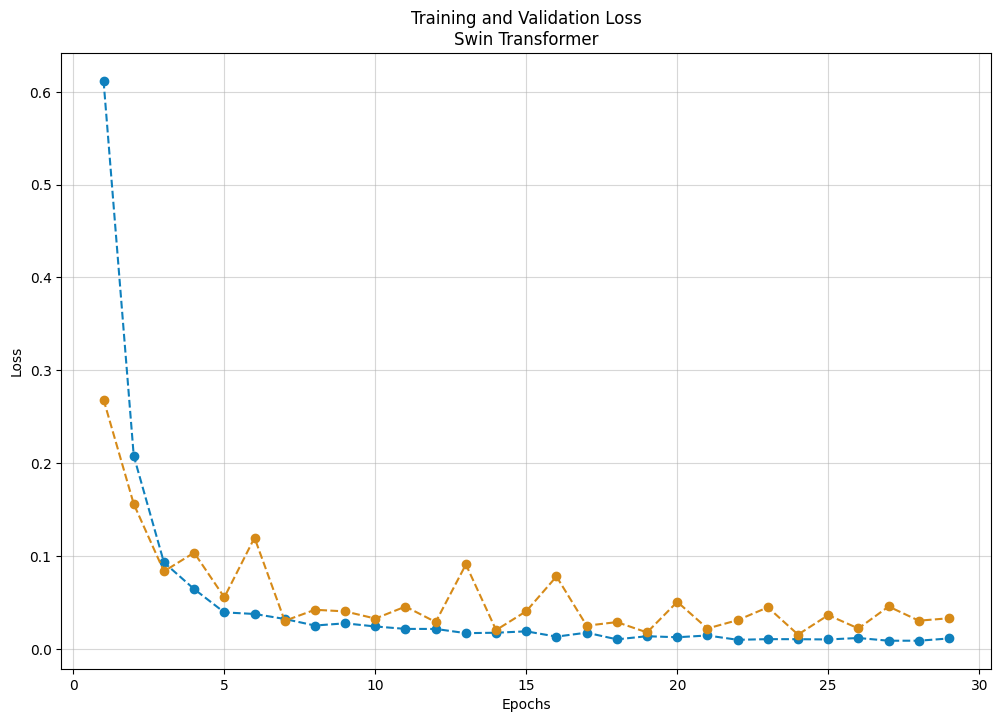

In [9]:
# Plot

t = [i + 1 for i in range(len(train_loss_array))]

plt.figure(figsize=(12, 8))

plt.plot(t, train_loss_array, color='#0f80bd',linestyle='--', marker='o', label='Training Loss')
plt.plot(t, val_loss_array, color='#d68a18', linestyle='--', marker='o', label='Validation Loss')

plt.title(f'Training and Validation Loss\nSwin Transformer')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True, alpha=0.5)

plt.savefig('Loss_Swin.png', dpi=600)

plt.show()

100%|██████████| 160/160 [00:46<00:00,  3.41it/s]


Accuracy: 0.9945
Precision: 0.9945
Recall: 0.9945
F1 Score: 0.9945
Jaccard Index: 0.9891
MCC: 0.9926
AUC: 0.9999


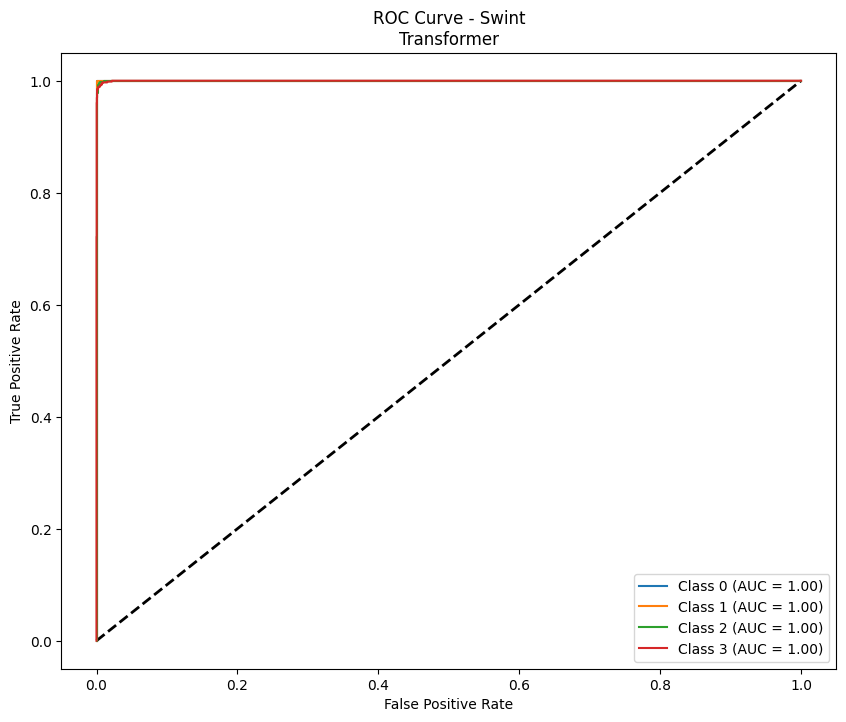

In [12]:
# Testing

csv_path = 'swin_metrics.csv'
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

model.eval()
y_true = []
y_pred_prob_list = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_pred_prob_list.append(probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred_prob = np.concatenate(y_pred_prob_list, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
jaccard = jaccard_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true_bin, y_pred_prob, multi_class='ovr')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"AUC: {auc_score:.4f}")

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Jaccard Index', 'MCC', 'AUC'],
    'Value': [accuracy, precision, recall, f1, jaccard, mcc, auc_score]
}
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(csv_path, index=False)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', lw=2)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Swint\nTransformer')
plt.legend(loc='lower right')
plt.savefig('ROC_Swin.png', dpi=600)
plt.show()